In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
import pandas as pd
sns.set_style('white')

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

#Toy Dataset
x1 = np.array([1, 1, 2, 2, 3, 3, 3, 4, 5, 5])
x2 = np.array([1, 3, 2, 4, 1, 2, 5, 4,   2, 5])
y = np.array([ 1, 1,-1, 1,-1, -1, 1, 1,  -1,-1])
X = np.vstack((x1,x2)).T
df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})


def plot_decision_boundary(classifier, X, y, N = 10, scatter_weights = np.ones(len(y)) , ax = None ):
    '''Utility function to plot decision boundary and scatter plot of data'''
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))

    
    #Check what methods are available
    if hasattr(classifier, "decision_function"):
        zz = np.array( [classifier.decision_function(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
    elif hasattr(classifier, "predict_proba"):
        zz = np.array( [classifier.predict_proba(np.array([xi,yi]).reshape(1,-1))[:,1] for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
    else :
        zz = np.array( [classifier(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
            
    # reshape result and plot
    Z = zz.reshape(xx.shape)
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    #Get current axis and plot
    if ax is None:
        ax = plt.gca()
    ax.contourf(xx, yy, Z, 2, cmap='RdBu', alpha=.5)
    ax.contour(xx, yy, Z,  2, cmap='RdBu')
    ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright, s = scatter_weights * 40)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')

def AdaBoost_scratch(X,y, M=3, learning_rate = 1):
    #Initialization of utility variables
    N = len(y)
    estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [], [],[],[],[]

    #Initialize the sample weights
    sample_weight = np.ones(N) / N
    sample_weight_list.append(sample_weight.copy())

    #For m = 1 to M
    for m in range(M):   

        #Fit a classifier
        estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
        estimator.fit(X, y, sample_weight=sample_weight)
        y_predict = estimator.predict(X)

        #Misclassifications
        incorrect = (y_predict != y)

        #Estimator error
        estimator_error = np.mean( np.average(incorrect, weights=sample_weight, axis=0))
        
        #Boost estimator weights
        estimator_weight =  learning_rate * np.log((1. - estimator_error) / estimator_error)

        #Boost sample weights
        sample_weight *= np.exp(estimator_weight * incorrect * ((sample_weight > 0) | (estimator_weight < 0)))

        #Save iteration values
        estimator_list.append(estimator)
        y_predict_list.append(y_predict.copy())
        estimator_error_list.append(estimator_error.copy())
        estimator_weight_list.append(estimator_weight.copy())
        sample_weight_list.append(sample_weight.copy())
        


    #Convert to np array for convenience   
    estimator_list = np.asarray(estimator_list)
    y_predict_list = np.asarray(y_predict_list)
    estimator_error_list = np.asarray(estimator_error_list)
    estimator_weight_list = np.asarray(estimator_weight_list)
    sample_weight_list = np.asarray(sample_weight_list)

    #Predictions
    preds = (np.array([np.sign((y_predict_list[:,point] * estimator_weight_list).sum()) for point in range(N)]))
    print('Accuracy = ', (preds == y).sum() / N) 
    
    return estimator_list, estimator_weight_list, sample_weight_list

def adaboost_steps(df, L=1):
    df['Stump 1']=np.sign(x2-2.5).astype(int)
    df['Weight 1'] = np.repeat(1/len(df), len(df))
    e1 = df[df['Stump 1']*df['y']==-1]['Weight 1'].sum()

    alpha1 = L*.5*np.log((1-e1)/e1)
    alpha1
    df['Weight 2'] = df['Weight 1']*np.exp(alpha1*(-df['y']*df['Stump 1']))
    df['Weight 2'] = df['Weight 2']/sum(df['Weight 2'])
    df

    df['Stump 2']=-np.sign(x1-1.5).astype(int)
    
    e2 = df[df['Stump 2']*df['y']==-1]['Weight 2'].sum()

    alpha2 = L*.5*np.log((1-e2)/e2)
    df['Weight 3'] = df['Weight 2']*np.exp(alpha2*(-df['y']*df['Stump 2']))
    df['Weight 3'] = df['Weight 3']/sum(df['Weight 3'])

    df['Stump 3']=-np.sign(x1-4.5).astype(int)
    e3 = df[df['Stump 3']*df['y']==-1]['Weight 3'].sum()

    alpha3 = L*.5*np.log((1-e3)/e3)

    return df

def plot_AdaBoost_scratch_boundary(estimators,estimator_weights, X, y, N = 10,ax = None ):
    
    def AdaBoost_scratch_classify(x_temp, est,est_weights ):
        '''Return classification prediction for a given point X and a previously fitted AdaBoost'''
        temp_pred = np.asarray( [ (e.predict(x_temp)).T* w for e, w in zip(est,est_weights )]  ) / est_weights.sum()
        return np.sign(temp_pred.sum(axis = 0))
    
    
    '''Utility function to plot decision boundary and scatter plot of data'''
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))


    zz = np.array( [AdaBoost_scratch_classify(np.array([xi,yi]).reshape(1,-1), estimators,estimator_weights ) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
            
    # reshape result and plot
    Z = zz.reshape(xx.shape)
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    if ax is None:
        ax = plt.gca()
    ax.contourf(xx, yy, Z, 2, cmap='RdBu', alpha=.5)
    ax.contour(xx, yy, Z,  2, cmap='RdBu')
    ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')


# Example 1

In [2]:
#Toy Dataset
x1 = np.array([1, 1, 2, 2, 3, 3, 3, 4, 5, 5])
x2 = np.array([1, 3, 2, 4, 1, 2, 5, 4,   2, 5])
y = np.array([ 1, 1,-1, 1,-1, -1, 1, 1,  -1,-1])
X = np.vstack((x1,x2)).T
df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})

adaboost_steps(df, L=1)

,x1,x2,y,Stump 1,Weight 1,Weight 2,Stump 2,Weight 3,Stump 3
0,1,1,1,-1,0.1,0.2500,1,0.153846,1
1,1,3,1,1,0.1,0.0625,1,0.038462,1
2,2,2,-1,-1,0.1,0.0625,-1,0.038462,1
3,2,4,1,1,0.1,0.0625,-1,0.166667,1
4,3,1,-1,-1,0.1,0.0625,-1,0.038462,1
5,3,2,-1,-1,0.1,0.0625,-1,0.038462,1
6,3,5,1,1,0.1,0.0625,-1,0.166667,1
7,4,4,1,1,0.1,0.0625,-1,0.166667,1
8,5,2,-1,-1,0.1,0.0625,-1,0.038462,-1
9,5,5,-1,1,0.1,0.2500,-1,0.153846,-1


In [3]:
adaboost_steps(df, L=.01)

,x1,x2,y,Stump 1,Weight 1,Weight 2,Stump 2,Weight 3,Stump 3
0,1,1,1,-1,0.1,0.101114,1,0.100856,1
1,1,3,1,1,0.1,0.099722,1,0.099467,1
2,2,2,-1,-1,0.1,0.099722,-1,0.099467,1
3,2,4,1,1,0.1,0.099722,-1,0.100318,1
4,3,1,-1,-1,0.1,0.099722,-1,0.099467,1
5,3,2,-1,-1,0.1,0.099722,-1,0.099467,1
6,3,5,1,1,0.1,0.099722,-1,0.100318,1
7,4,4,1,1,0.1,0.099722,-1,0.100318,1
8,5,2,-1,-1,0.1,0.099722,-1,0.099467,-1
9,5,5,-1,1,0.1,0.101114,-1,0.100856,-1


In [4]:
L=1
from tabulate import tabulate
df['Stump 1']=np.sign(x2-2.5).astype(int)
df['Weight 1'] = np.repeat(1/len(df), len(df))
e1 = df[df['Stump 1']*df['y']==-1]['Weight 1'].sum()


alpha1 = L*.5*np.log((1-e1)/e1)
alpha1
df['Weight 2'] = df['Weight 1']*np.exp(alpha1*(-df['y']*df['Stump 1']))
df['Weight 2'] = df['Weight 2']/sum(df['Weight 2'])
df

df['Stump 2']=-np.sign(x1-1.5).astype(int)

e2 = df[df['Stump 2']*df['y']==-1]['Weight 2'].sum()

alpha2 = L*.5*np.log((1-e2)/e2)
df['Weight 3'] = df['Weight 2']*np.exp(alpha2*(-df['y']*df['Stump 2']))
df['Weight 3'] = df['Weight 3']/sum(df['Weight 3'])

df['Stump 3']=-np.sign(x1-4.5).astype(int)
e3 = df[df['Stump 3']*df['y']==-1]['Weight 3'].sum()

alpha3 = L*.5*np.log((1-e3)/e3)

In [5]:
alpha1

0.6931471805599453

In [5]:
df = adaboost_steps(df, L=1)
print(tabulate(df, headers="keys", tablefmt="github"))

|    |   x1 |   x2 |   y |   Stump 1 |   Weight 1 |   Weight 2 |   Stump 2 |   Weight 3 |   Stump 3 |
|----|------|------|-----|-----------|------------|------------|-----------|------------|-----------|
|  0 |    1 |    1 |   1 |        -1 |        0.1 |     0.25   |         1 |  0.153846  |         1 |
|  1 |    1 |    3 |   1 |         1 |        0.1 |     0.0625 |         1 |  0.0384615 |         1 |
|  2 |    2 |    2 |  -1 |        -1 |        0.1 |     0.0625 |        -1 |  0.0384615 |         1 |
|  3 |    2 |    4 |   1 |         1 |        0.1 |     0.0625 |        -1 |  0.166667  |         1 |
|  4 |    3 |    1 |  -1 |        -1 |        0.1 |     0.0625 |        -1 |  0.0384615 |         1 |
|  5 |    3 |    2 |  -1 |        -1 |        0.1 |     0.0625 |        -1 |  0.0384615 |         1 |
|  6 |    3 |    5 |   1 |         1 |        0.1 |     0.0625 |        -1 |  0.166667  |         1 |
|  7 |    4 |    4 |   1 |         1 |        0.1 |     0.0625 |        -1 |  0.16

In [6]:
alpha3

1.0184409636305198

## Plotting

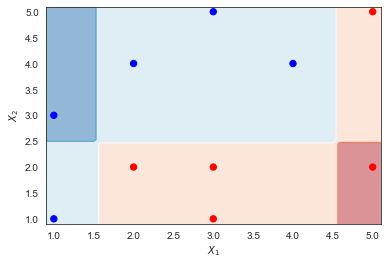

Accuracy =  1.0


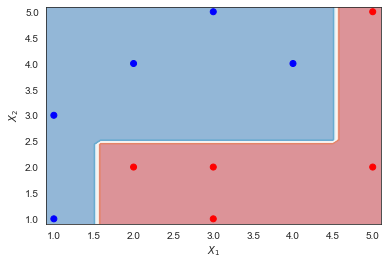

In [7]:
# Plot

round = 3
L = 1

boost = AdaBoostClassifier( base_estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2), 
                            algorithm = 'SAMME',n_estimators=round, learning_rate=L)
boost.fit(X,y)
plot_decision_boundary(boost, X,y, N = 50)#, weights)
plt.show()

estimator_list, estimator_weight_list, sample_weight_list  = AdaBoost_scratch(X,y, M=round, learning_rate = L)
plot_AdaBoost_scratch_boundary(estimator_list, estimator_weight_list, X, y, N = 50 )

## ========================================

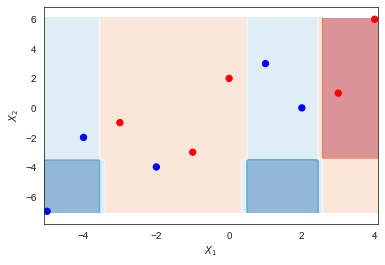

Accuracy =  0.9


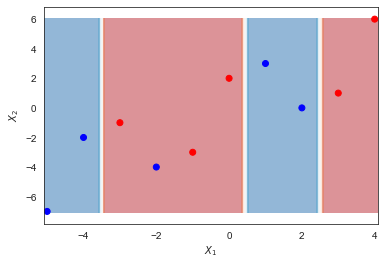

In [9]:
x1 = np.array(np.arange(-5, 5))
x2 = x1^2
y = np.array([ 1, 1,-1, 1,-1, -1, 1, 1,  -1,-1])
X = np.vstack((x1,x2)).T
df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})

adaboost_steps(df, L=1)
round = 4
L = 1

boost = AdaBoostClassifier( base_estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2), 
                            algorithm = 'SAMME',n_estimators=round, learning_rate=L)
boost.fit(X,y)
plot_decision_boundary(boost, X,y, N = 50)#, weights)
plt.show()

estimator_list, estimator_weight_list, sample_weight_list  = AdaBoost_scratch(X,y, M=round, learning_rate = L)
plot_AdaBoost_scratch_boundary(estimator_list, estimator_weight_list, X, y, N = 50 )

# Example 2

   x1  x2  y  Stump 1  Weight 1  Weight 2  Stump 2  Weight 3  Stump 3
0   1   1  1       -1  0.166667     0.250        1  0.142857        1
1   1   3  1        1  0.166667     0.125        1  0.071429        1
2   2   2 -1       -1  0.166667     0.125       -1  0.071429        1
3   2   4  1        1  0.166667     0.125       -1  0.500000        1
4   4   4 -1        1  0.166667     0.250       -1  0.142857        1
5   5   2 -1       -1  0.166667     0.125       -1  0.071429       -1
--------------------------------------------------------------------------------
errors: [0.3333333333333333, 0.125, 0.21428571428571436]


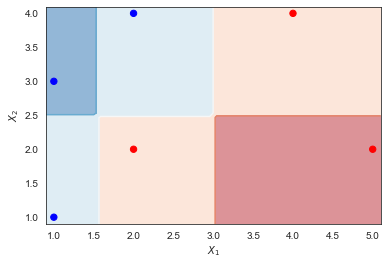

Accuracy =  1.0


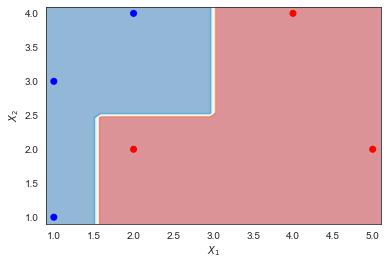

In [10]:
import pandas as pd
# pd.DataFrame({'x1':x1, 'x2':x2, 'y':y}).to_csv('1.csv')

x1 = np.array([1, 1, 2, 2,    4, 5])
x2 = np.array([1, 3, 2, 4,    4,   2])
X = np.vstack((x1,x2)).T
y = np.array([ 1, 1,-1, 1,   -1,  -1])

round = 4
L = 1

df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})
df['Stump 1']=np.sign(x2-2.5).astype(int)
df['Weight 1'] = np.repeat(1/len(df), len(df))
e1 = df[df['Stump 1']*df['y']==-1]['Weight 1'].sum()

df
alpha1 = L*.5*np.log((1-e1)/e1)
alpha1
df['Weight 2'] = df['Weight 1']*np.exp(alpha1*(-df['y']*df['Stump 1']))
df['Weight 2'] = df['Weight 2']/sum(df['Weight 2'])
df

df['Stump 2']=-np.sign(x1-1.5).astype(int)
df
e2 = df[df['Stump 2']*df['y']==-1]['Weight 2'].sum()

alpha2 = L*.5*np.log((1-e2)/e2)
alpha2
df['Weight 3'] = df['Weight 2']*np.exp(alpha2*(-df['y']*df['Stump 2']))
df['Weight 3'] = df['Weight 3']/sum(df['Weight 3'])
df

df['Stump 3']=-np.sign(x1-4.5).astype(int)
df
e3 = df[df['Stump 3']*df['y']==-1]['Weight 3'].sum()

alpha3 = L*.5*np.log((1-e3)/e3)
alpha3

print(df)
print('--------------------------------------------------------------------------------')
print('errors:',[e1, e2, e3])


# Plot

boost = AdaBoostClassifier( base_estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2), 
                            algorithm = 'SAMME',n_estimators=round, learning_rate=L)
boost.fit(X,y)
plot_decision_boundary(boost, X,y, N = 50)#, weights)
plt.show()

estimator_list, estimator_weight_list, sample_weight_list  = AdaBoost_scratch(X,y, M=round, learning_rate = L)
plot_AdaBoost_scratch_boundary(estimator_list, estimator_weight_list, X, y, N = 50 )

   x1  x2  y  Stump 1  Weight 1  Weight 2  Stump 2  Weight 3  Stump 3
0   1   1  1        1  0.166667       0.1        1  0.055556       -1
1   1   3  1        1  0.166667       0.1        1  0.055556        1
2   2   2 -1        1  0.166667       0.5       -1  0.277778       -1
3   2   4  1        1  0.166667       0.1       -1  0.500000        1
4   4   4 -1       -1  0.166667       0.1       -1  0.055556        1
5   5   2 -1       -1  0.166667       0.1       -1  0.055556       -1
--------------------------------------------------------------------------------
errors: [0.16666666666666666, 0.1, 0.11111111111111109]
Accuracy =  1.0


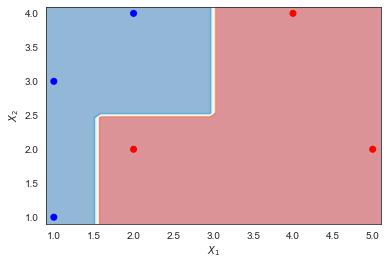

In [11]:
import pandas as pd
# pd.DataFrame({'x1':x1, 'x2':x2, 'y':y}).to_csv('1.csv')

x1 = np.array([1, 1, 2, 2,    4, 5])
x2 = np.array([1, 3, 2, 4,    4,   2])
X = np.vstack((x1,x2)).T
y = np.array([ 1, 1,-1, 1,   -1,  -1])

df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})
df['Stump 1']=-np.sign(x1-3).astype(int)

df['Weight 1'] = np.repeat(1/len(df), len(df))
e1 = df[df['Stump 1']*df['y']==-1]['Weight 1'].sum()

alpha1 = .5*np.log((1-e1)/e1)
alpha1
df['Weight 2'] = df['Weight 1']*np.exp(alpha1*(-df['y']*df['Stump 1']))
df['Weight 2'] = df['Weight 2']/sum(df['Weight 2'])
df

df['Stump 2']=-np.sign(x1-1.5).astype(int)
df
e2 = df[df['Stump 2']*df['y']==-1]['Weight 2'].sum()

alpha2 = .5*np.log((1-e2)/e2)
alpha2
df['Weight 3'] = df['Weight 2']*np.exp(alpha2*(-df['y']*df['Stump 2']))
df['Weight 3'] = df['Weight 3']/sum(df['Weight 3'])
df

df['Stump 3']=np.sign(x2-2.5).astype(int)
df
e3 = df[df['Stump 3']*df['y']==-1]['Weight 3'].sum()

alpha3 = .5*np.log((1-e3)/e3)
alpha3
print(df)
print('--------------------------------------------------------------------------------')
print('errors:',[e1, e2, e3])

round = 20
L = .1

estimator_list, estimator_weight_list, sample_weight_list  = AdaBoost_scratch(X,y, M=round, learning_rate = L)
plot_AdaBoost_scratch_boundary(estimator_list, estimator_weight_list, X, y, N = 50 )

In [12]:
def plot_AdaBoost_scratch_boundary(estimators,estimator_weights, X, y, N = 10,ax = None ):
    
    def AdaBoost_scratch_classify(x_temp, est,est_weights ):
        '''Return classification prediction for a given point X and a previously fitted AdaBoost'''
        temp_pred = np.asarray( [ (e.predict(x_temp)).T* w for e, w in zip(est,est_weights )]  ) / est_weights.sum()
        return np.sign(temp_pred.sum(axis = 0))
    
    
    '''Utility function to plot decision boundary and scatter plot of data'''
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))


    zz = np.array( [AdaBoost_scratch_classify(np.array([xi,yi]).reshape(1,-1), estimators,estimator_weights ) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
            
    # reshape result and plot
    Z = zz.reshape(xx.shape)
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    if ax is None:
        ax = plt.gca()
    ax.contourf(xx, yy, Z, 2, cmap='RdBu', alpha=.5)
    ax.contour(xx, yy, Z,  2, cmap='RdBu')
    ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')


Accuracy =  1.0


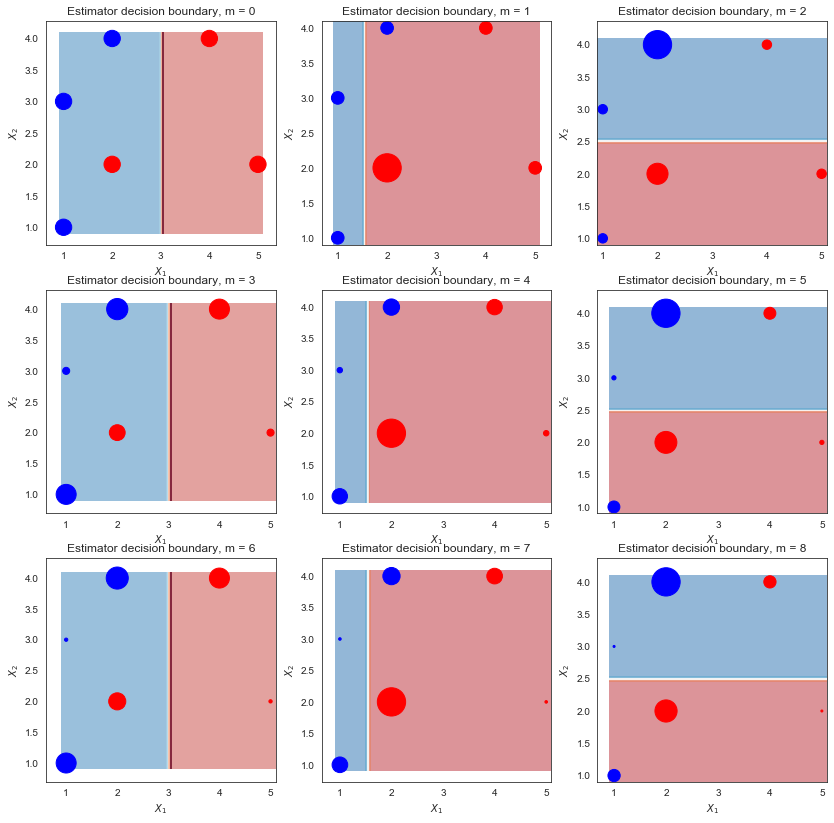

In [13]:
estimator_list, estimator_weight_list, sample_weight_list  = AdaBoost_scratch(X,y, M=10, learning_rate = 1)

fig = plt.figure(figsize = (14,14))
for m in range(0,9):
    fig.add_subplot(3,3,m+1)
    s_weights = (sample_weight_list[m,:] / sample_weight_list[m,:].sum() ) * 40
    plot_decision_boundary(estimator_list[m], X,y,N = 50, scatter_weights =s_weights )
    plt.title('Estimator decision boundary, m = {}'.format(m))


## Exam 2 Practice Problems

|    |   x1 |   x2 |   y |
|----|------|------|-----|
|  0 |    1 |    2 |   1 |
|  1 |    2 |    5 |   1 |
|  2 |    3 |    4 |  -1 |
|  3 |    4 |    0 |  -1 |
|  4 |    0 |    1 |  -1 |
[0.693 0.973 1.282]
Accuracy =  1.0
|    |   x1 |   x2 |   y |   Stump 1 |   Weight 1 |   Weight 2 |   Stump 2 |   Weight 3 |   Stump 3 |   Final |
|----|------|------|-----|-----------|------------|------------|-----------|------------|-----------|---------|
|  0 |    1 |    2 |   1 |         1 |        0.2 |      0.125 |         1 |  0.0714286 |        -1 |       1 |
|  1 |    2 |    5 |   1 |         1 |        0.2 |      0.125 |         1 |  0.0714286 |         1 |       1 |
|  2 |    3 |    4 |  -1 |        -1 |        0.2 |      0.125 |         1 |  0.5       |        -1 |      -1 |
|  3 |    4 |    0 |  -1 |        -1 |        0.2 |      0.125 |        -1 |  0.0714286 |        -1 |      -1 |
|  4 |    0 |    1 |  -1 |         1 |        0.2 |      0.5   |        -1 |  0.285714  |        -1 |  

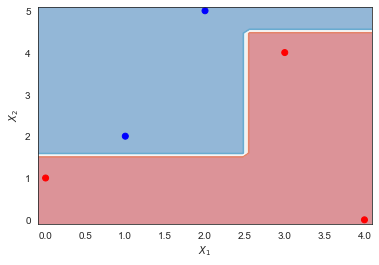

In [14]:
#Toy Dataset
x1 = np.array([1, 2, 3, 4, 0])
x2 = np.array([2, 5, 4, 0, 1])
y = np.array([ 1, 1,-1, -1,-1])
X = np.vstack((x1,x2)).T
df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})
print(tabulate(df, headers="keys",tablefmt="github"))
def adaboost_steps(df, L=1):
    df['Stump 1']=-np.sign(x1-2.5).astype(int)
    df['Weight 1'] = np.repeat(1/len(df), len(df))
    e1 = df[df['Stump 1']*df['y']==-1]['Weight 1'].sum()

    alpha1 = L*.5*np.log((1-e1)/e1)
    alpha1
    df['Weight 2'] = df['Weight 1']*np.exp(alpha1*(-df['y']*df['Stump 1']))
    df['Weight 2'] = df['Weight 2']/sum(df['Weight 2'])
    df

    df['Stump 2']=np.sign(x2-1.5).astype(int)
    
    e2 = df[df['Stump 2']*df['y']==-1]['Weight 2'].sum()

    alpha2 = L*.5*np.log((1-e2)/e2)
    df['Weight 3'] = df['Weight 2']*np.exp(alpha2*(-df['y']*df['Stump 2']))
    df['Weight 3'] = df['Weight 3']/sum(df['Weight 3'])

    df['Stump 3']=np.sign(x2-4.5).astype(int)
    e3 = df[df['Stump 3']*df['y']==-1]['Weight 3'].sum()

    alpha3 = L*.5*np.log((1-e3)/e3)
    
    df['Final'] = np.sign(alpha1*df['Stump 1'] + alpha2*df['Stump 2'] + alpha3*df['Stump 3'] )
    print(np.round([alpha1, alpha2, alpha3], 3))

    return df

adaboost_steps(df, L=1)

round = 3
L = 1

estimator_list, estimator_weight_list, sample_weight_list  = AdaBoost_scratch(X,y, M=round, learning_rate = L)
plot_AdaBoost_scratch_boundary(estimator_list, estimator_weight_list, X, y, N = 50 )

print(tabulate(df, headers="keys",tablefmt="github"))

## Exam 2 Problem 

|    |   x1 |   x2 |   y |
|----|------|------|-----|
|  0 |    1 |   -1 |   1 |
|  1 |    2 |    3 |  -1 |
|  2 |    3 |    4 |   1 |
|  3 |    4 |   -2 |  -1 |
|  4 |    0 |    1 |  -1 |
[0.2   0.25  0.167]
[0.693 0.549 0.805]


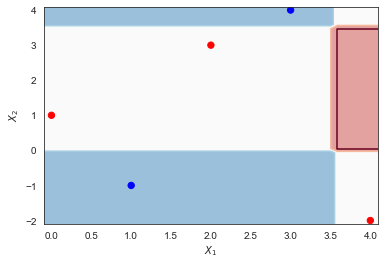

Accuracy =  1.0
|    |   x1 |   x2 |   y |   Stump 1 |   Weight 1 |   Weight 2 |   Stump 2 |   Weight 3 |   Stump 3 |   Final |
|----|------|------|-----|-----------|------------|------------|-----------|------------|-----------|---------|
|  0 |    1 |   -1 |   1 |        -1 |        0.2 |      0.5   |         1 |  0.333333  |         1 |       1 |
|  1 |    2 |    3 |  -1 |        -1 |        0.2 |      0.125 |         1 |  0.25      |        -1 |      -1 |
|  2 |    3 |    4 |   1 |         1 |        0.2 |      0.125 |         1 |  0.0833333 |        -1 |       1 |
|  3 |    4 |   -2 |  -1 |        -1 |        0.2 |      0.125 |        -1 |  0.0833333 |         1 |      -1 |
|  4 |    0 |    1 |  -1 |        -1 |        0.2 |      0.125 |         1 |  0.25      |        -1 |      -1 |


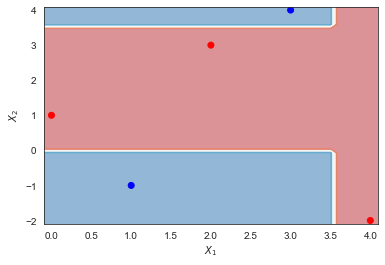

In [22]:
#Toy Dataset
x1 = np.array([1, 2, 3, 4, 0])
x2 = np.array([-1, 3, 4, -2, 1])
y = np.array([ 1, -1,1, -1,-1])
X = np.vstack((x1,x2)).T
df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})
print(tabulate(df, headers="keys",tablefmt="github"))

# Stump 1:  x2>3.5
# Stump 2:  x1<3.5
# Stump 3:  x2<0

def adaboost_steps(df, L=1):
    
    # Stump 1:  x2>3.5
    df['Stump 1']=np.sign(x2-3.5).astype(int)
    df['Weight 1'] = np.repeat(1/len(df), len(df))
    e1 = df[df['Stump 1']*df['y']==-1]['Weight 1'].sum()

    alpha1 = L*.5*np.log((1-e1)/e1)
    alpha1
    df['Weight 2'] = df['Weight 1']*np.exp(alpha1*(-df['y']*df['Stump 1']))
    df['Weight 2'] = df['Weight 2']/sum(df['Weight 2'])
    
    # Stump 2:  x1<3.5
    df['Stump 2']=-np.sign(x1-3.5).astype(int)
    
    e2 = df[df['Stump 2']*df['y']==-1]['Weight 2'].sum()

    alpha2 = L*.5*np.log((1-e2)/e2)
    df['Weight 3'] = df['Weight 2']*np.exp(alpha2*(-df['y']*df['Stump 2']))
    df['Weight 3'] = df['Weight 3']/sum(df['Weight 3'])

    # Stump 3:  x2<0
    df['Stump 3']=-np.sign(x2).astype(int)
    e3 = df[df['Stump 3']*df['y']==-1]['Weight 3'].sum()

    alpha3 = L*.5*np.log((1-e3)/e3)
    
    df['Final'] = np.sign(alpha1*df['Stump 1'] + alpha2*df['Stump 2'] + alpha3*df['Stump 3'] )
    print(np.round([e1, e2, e3], 3))
    print(np.round([alpha1, alpha2, alpha3], 3))
    return df

adaboost_steps(df, L=1)

round = 3
L = 1

boost = AdaBoostClassifier( base_estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2), 
                            algorithm = 'SAMME',n_estimators=round, learning_rate=L)
boost.fit(X,y)
plot_decision_boundary(boost, X,y, N = 50)#, weights)
plt.show()


estimator_list, estimator_weight_list, sample_weight_list  = AdaBoost_scratch(X,y, M=round, learning_rate = L)
plot_AdaBoost_scratch_boundary(estimator_list, estimator_weight_list, X, y, N = 50 )

print(tabulate(df, headers="keys",tablefmt="github"))

In [8]:
x1 = np.array([1, 1, 2, 2, 3, 3, 3, 4, 5, 5])
x2 = np.array([1, 3, 2, 4, 1, 2, 5, 4,   2, 5])
y = np.array([ 1, 1,-1, 1,-1, -1, 1, 1,  -1,-1])
X = np.vstack((x1,x2)).T
df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})

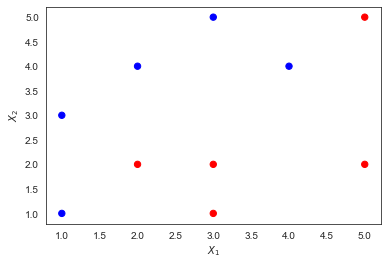

In [16]:
ax = plt.gca()
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
scatter_weights = np.ones(len(y))
ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright, s = scatter_weights* 40)
ax.set_xlabel('$X_1$')
ax.set_ylabel('$X_2$')
plt.savefig('ada_scatter.png')

Accuracy =  1.0


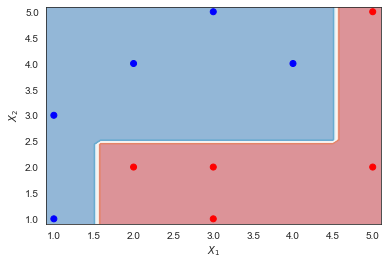

In [15]:
estimator_list, estimator_weight_list, sample_weight_list  = AdaBoost_scratch(X,y, M=round, learning_rate = L)
plot_AdaBoost_scratch_boundary(estimator_list, estimator_weight_list, X, y, N = 50 )